In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import numpy as np
import math
from copy import deepcopy

In [32]:
def to_var(x, requires_grad=False):
    """
    Automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return x.clone().detach().requires_grad_(requires_grad)


class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
        self.mask = None

    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

    def forward(self, x):
        if self.mask_flag:
            weight = self.weight * self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [33]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = MaskedLinear(28 * 28, 200)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = MaskedLinear(200, 200)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear3 = MaskedLinear(200, 10)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.relu1(self.linear1(out))
        out = self.relu2(self.linear2(out))
        out = self.linear3(out)
        return out

    def set_masks(self, masks):
        # Should be a less manual way to set masks
        # Leave it for the future
        self.linear1.set_mask(masks[0])
        self.linear2.set_mask(masks[1])
        self.linear3.set_mask(masks[2])

In [34]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        total += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, total, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')

In [35]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [36]:
def weight_prune(model, pruning_perc):
    '''
    Prune pruning_perc % weights layer-wise
    '''
    threshold_list = []
    for p in model.parameters():
        if len(p.data.size()) != 1: # bias
            weight = p.cpu().data.abs().numpy().flatten()
            threshold = np.percentile(weight, pruning_perc)
            threshold_list.append(threshold)

    # generate mask
    masks = []
    idx = 0
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold_list[idx]
            masks.append(pruned_inds.float())
            idx += 1
    return masks

In [43]:
def main():
    epochs = 2
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = MLP().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        _, acc = test(model, device, test_loader)
    
    print("\n=====Pruning 60%=======\n")
    pruned_model = deepcopy(model)
    mask = weight_prune(pruned_model, 60)
    pruned_model.set_masks(mask)
    test(pruned_model, device, test_loader)
        
    return model, pruned_model

In [49]:
model, pruned_model = main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1098, accuracy: 9655/10000 (97%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0898, accuracy: 9736/10000 (97%)

=====Pruning 60%=======


Test: average loss: 0.0840, accuracy: 9731/10000 (97%)


## 可视化

In [50]:
from matplotlib import pyplot as plt

In [51]:
def plot_weights(model):
    modules = [module for module in model.modules()]
    num_sub_plot = 0
    for i, layer in enumerate(modules):
        if hasattr(layer, 'weight'):
            plt.subplot(131+num_sub_plot)
            w = layer.weight.data
            w_one_dim = w.cpu().numpy().flatten()
            plt.hist(w_one_dim[w_one_dim!=0], bins=50)
            num_sub_plot += 1
    plt.show()


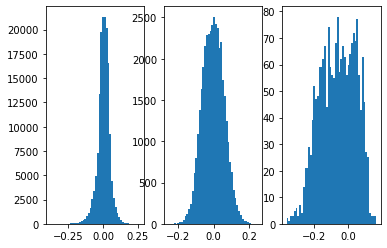

In [52]:
plot_weights(model)

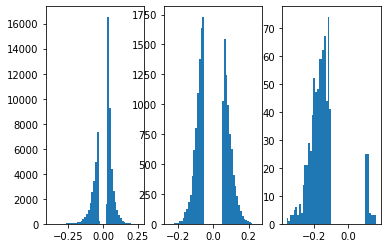

In [53]:
plot_weights(pruned_model)